# Big Data Analytics Techniques and Applications - HW1
#### 0316313 張逸群

## 資料
| ID | 資料名稱                | 資料大小 |
|----|-------------------------|----------|
| 1  | yellow_tripdata_2015-01 | 1.9GB    |
| 2  | yellow_tripdata_2015-02 | 1.9GB    |
|總計 |                         | 3.8GB    |

## 使用工具
* python3.7
    * numpy
    * sklearn
    * pandas
    * matplotlib
    * seaborn
    * folium
    * math
    * jupyter lab

## 環境
* Ubuntu 16
* Intel(R) Core(TM) i5-6600 CPU @ 3.30GHz
* 56GB ram


## 使用 `pandas` 讀取資料，並以 `pandas.DataFrame` 儲存

In [2]:
import numpy as np
import pandas as pd
import pandasql as ps
import os
import sys
import sklearn
import math

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
data_list = ['yellow_tripdata_2015-01', 'yellow_tripdata_2015-02']

In [4]:
df = None
for filename in data_list:
    print('reading', filename, '...', end='')
    if os.path.exists(filename + '.pl'):
        tmp_df = pd.read_pickle(filename + '.pl')
    else:
        tmp_df = pd.read_csv(filename + '.csv')
        tmp_df.to_pickle(filename + '.pl')
        
    if df is None: df = tmp_df
    else: df.append(tmp_df, ignore_index=True)
        
    print(' done!')

reading yellow_tripdata_2015-01 ... done!
reading yellow_tripdata_2015-02 ... done!


### 預覽資料

In [126]:
print(df.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1

### 取得統計資料

In [127]:
print(df.describe())

           VendorID  passenger_count  trip_distance  pickup_longitude  \
count  1.274899e+07     1.274899e+07   1.274899e+07      1.274899e+07   
mean   1.521437e+00     1.681491e+00   1.345913e+01     -7.256184e+01   
std    4.995402e-01     1.337924e+00   9.844094e+03      1.012510e+01   
min    1.000000e+00     0.000000e+00   0.000000e+00     -1.219258e+02   
25%    1.000000e+00     1.000000e+00   1.000000e+00     -7.399168e+01   
50%    2.000000e+00     1.000000e+00   1.680000e+00     -7.398160e+01   
75%    2.000000e+00     2.000000e+00   3.000000e+00     -7.396662e+01   
max    2.000000e+00     9.000000e+00   1.542000e+07      7.866265e+01   

       pickup_latitude    RateCodeID  dropoff_longitude  dropoff_latitude  \
count     1.274899e+07  1.274899e+07       1.274899e+07      1.274899e+07   
mean      3.997282e+01  1.036901e+00      -7.260904e+01      3.999961e+01   
std       5.578691e+00  6.732240e-01       9.966037e+00      5.487742e+00   
min       0.000000e+00  1.000000e+

# Q1. Which regions have most pickups and drop-offs?
## A1.

### 試著將 pickup 點視覺化

In [81]:
sampled_df = df.sample(n=10000)
sampled_df['constant'] = 0.0001

import folium
import folium.plugins

center = [4.074314e+01, -7.388160e+01]

m = folium.Map(center, zoom_start=11.5)
folium.plugins.HeatMap(sampled_df[['pickup_latitude', 'pickup_longitude', 'constant']].values.tolist()).add_to(m)
#m

![map](https://i.imgur.com/pJ7As2k.jpg)

### 不畫出地圖

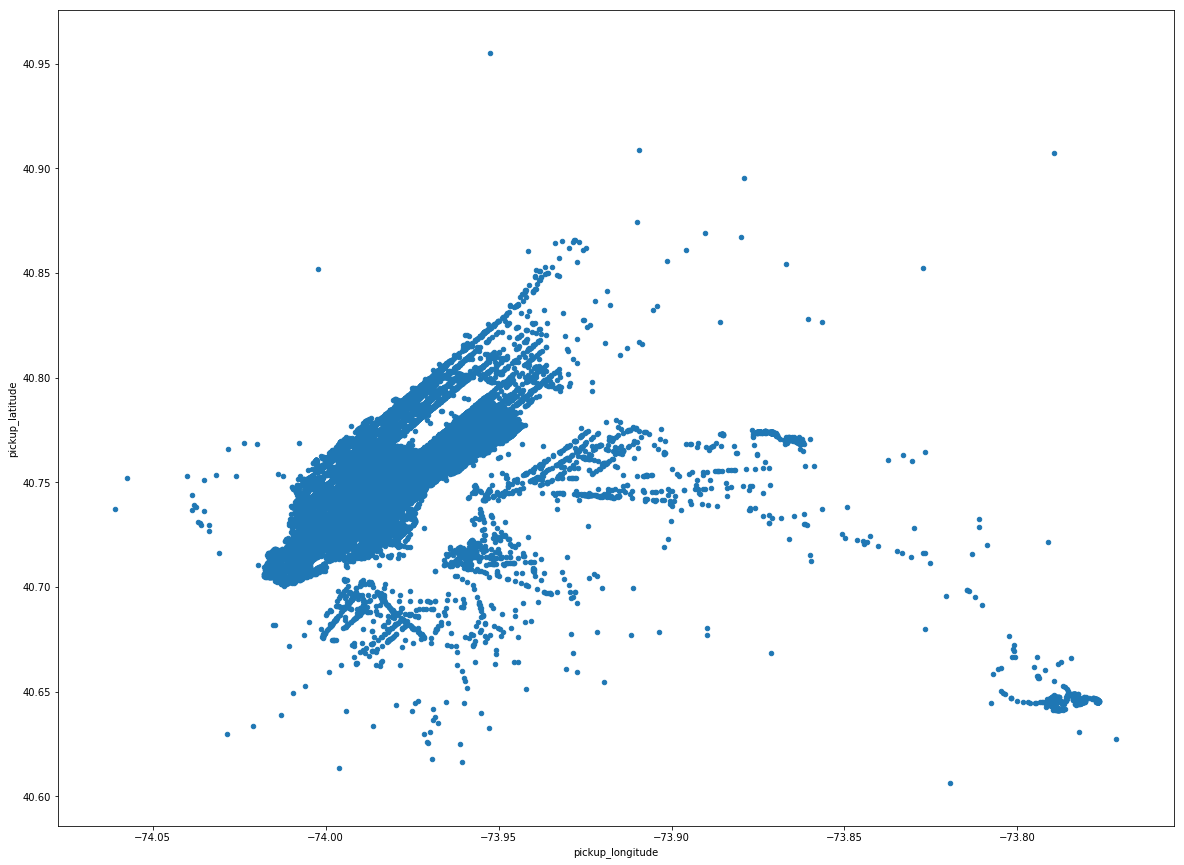

In [157]:
sampled_df = df.sample(n=50000)

sampled_df = sampled_df[
    (sampled_df.pickup_latitude > 40.6) &
    (sampled_df.pickup_longitude > -74.1) &
    (sampled_df.pickup_longitude < -73.75)
]

sampled_df.plot.scatter(x='pickup_longitude', y='pickup_latitude', figsize=(20, 15))
plt.show()

* 可以看出其中大概集中在以下幾點
    * 左上方長塊區
    * 左下方
    * 右上方
    * 中間
    * 右下方的機場區  

### 試著使用 DBSCAN - Density-Based Spatial Clustering 進行分群

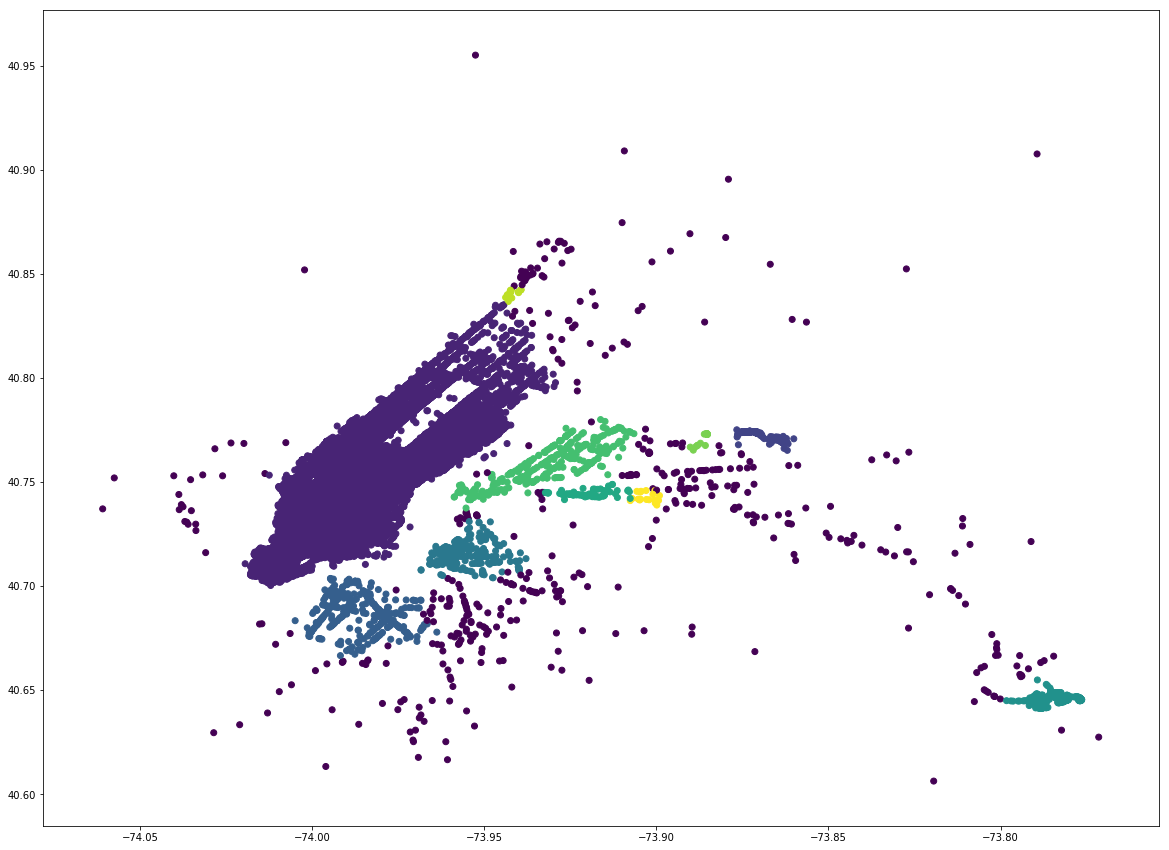

 0    45571
 1      903
 4      883
-1      459
 2      411
 6      377
 3      287
 5       92
 7       26
 9       21
 8       15
Name: cluster, dtype: int64


In [158]:
import sklearn.cluster
from math import sin, cos, sqrt, atan2, radians

dbscan = sklearn.cluster.DBSCAN(eps=0.005, min_samples=20, p=2, n_jobs=-1)
sampled_df['cluster'] = dbscan.fit_predict(sampled_df[['pickup_longitude', 'pickup_latitude']])

plt.figure(figsize=(20, 15))
plt.scatter(x=sampled_df['pickup_longitude'], y=sampled_df['pickup_latitude'], c=dbscan.labels_.astype(float))
plt.show()
print(sampled_df['cluster'].value_counts())


#### 編號 0 的 cluster 數量遠超過其他 cluster，因此將 0 拿出來另外分組

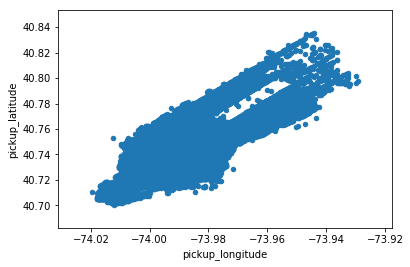

In [159]:
remain_df = sampled_df[sampled_df.cluster == 0]
remain_df.plot.scatter('pickup_longitude', 'pickup_latitude')

/home/toosyou/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


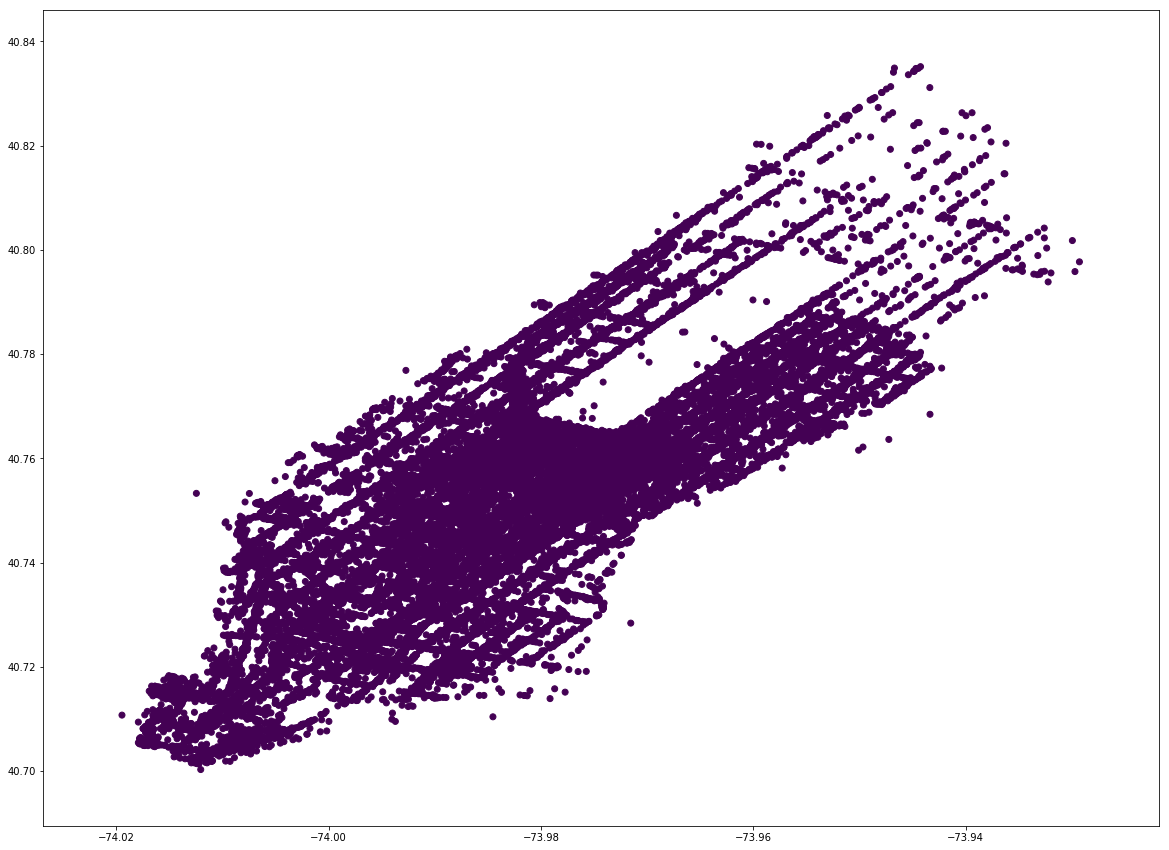

0    45571
Name: cluster, dtype: int64


In [169]:
import numba

@numba.jit
def geo_distance(a, b):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians( a[1] )
    lon1 = radians( a[0] )
    lat2 = radians( b[1] )
    lon2 = radians( b[0] )

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

dbscan_remain = sklearn.cluster.DBSCAN(eps=10, min_samples=20, p=2, n_jobs=-1, metric=geo_distance)
remain_df['cluster'] = dbscan_remain.fit_predict(remain_df[['pickup_longitude', 'pickup_latitude']])

plt.figure(figsize=(20, 15))
plt.scatter(x=remain_df['pickup_longitude'], y=remain_df['pickup_latitude'], c=dbscan_remain.labels_.astype(float))
plt.show()
print(remain_df['cluster'].value_counts())

### 這邊發現 DBSCAN 並不適合這個任務，改用 Gaussian Mixture 進行 clustering

/home/toosyou/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


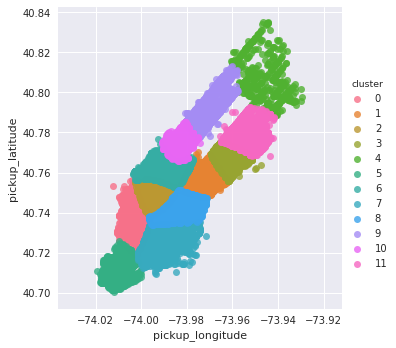

1     6695
6     5008
7     4983
8     4852
0     4415
2     4326
11    4098
3     3110
10    2698
9     2583
5     2216
4      587
Name: cluster, dtype: int64


In [188]:
import sklearn.mixture
import seaborn as sns

gm = sklearn.mixture.GaussianMixture(n_components=12)
gm.fit(remain_df[['pickup_longitude', 'pickup_latitude']])
remain_df['cluster'] = gm.predict(remain_df[['pickup_longitude', 'pickup_latitude']])

sns.lmplot('pickup_longitude', 'pickup_latitude', data=remain_df, hue='cluster', fit_reg=False)
plt.show()
print(remain_df['cluster'].value_counts())

## 結論
參照曼哈頓島的地圖：  
![manhaton_map](https://i.imgur.com/lpmuol1.gif)

* 可以發現依照 clustering 的結果，以 **Mildtown East** 較多，且面積較小，應是主要的 hot spot!

# Q2. When are the peak hours and off-peak hours for taking taxi?  
## A2. 將資料中的時間取出，將其小時的部分進行 bining ，便可以得到以下結果：

In [7]:
df['hour_of_day'] = [ t.hour for t in pd.to_datetime(df.tpep_pickup_datetime) ]
hod_count = df['hour_of_day'].value_counts()
print(hod_count)

19    805230
18    799587
20    733952
21    711579
22    686959
17    668790
14    658887
15    648688
12    637479
13    635587
11    596504
23    592429
9     580034
16    576598
10    567818
8     561802
0     469971
7     456127
1     355145
6     268455
2     268133
3     198524
4     143271
5     127437
Name: hour_of_day, dtype: int64


### 視覺化

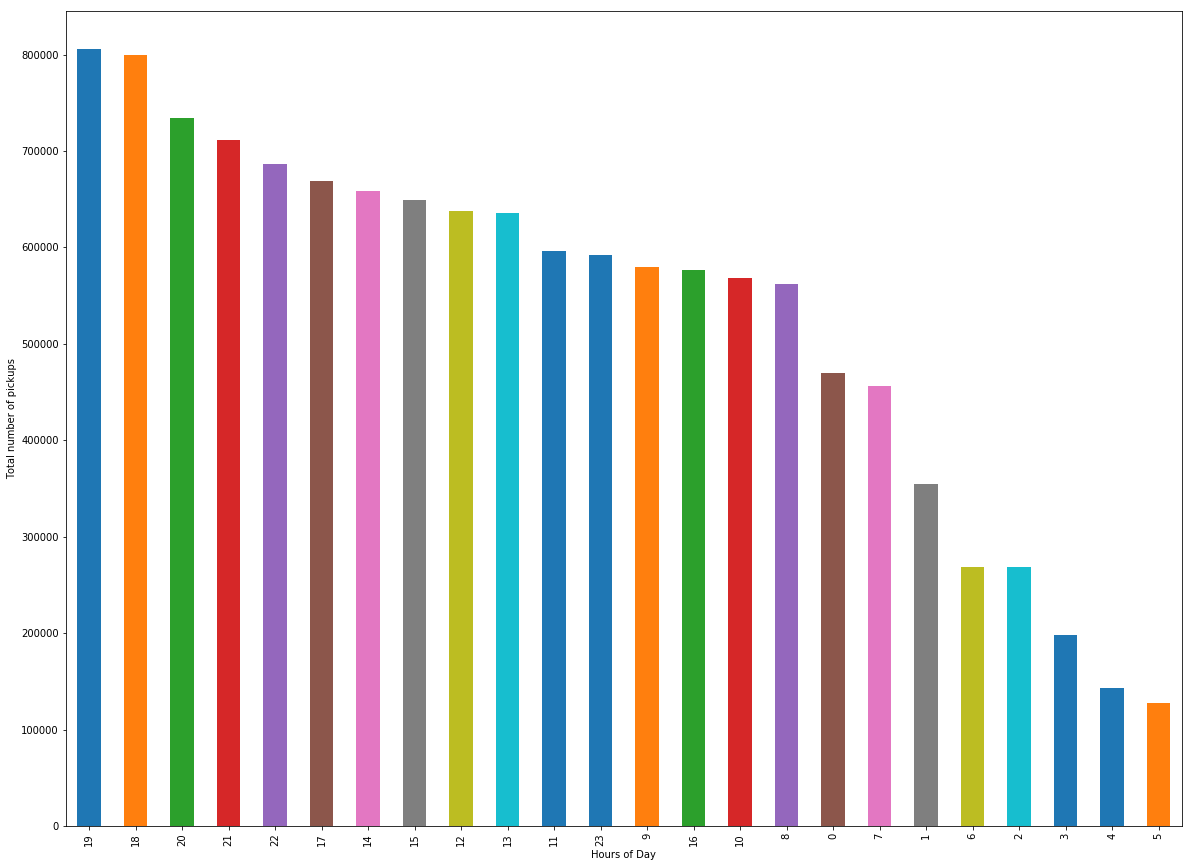

In [8]:
ax = hod_count.plot(kind='bar', figsize=(20, 15))
ax.set_xlabel('Hours of Day')
ax.set_ylabel('Total number of pickups')

## 結論
可以看出 peak-hours 以 **18:00 - 19:59** 兩個小時為主，而 off-peak-houres 為 **2:00 - 6:59** 五個小時

# Q3. What are the differences between short and long distance trips of taking taxi?
## A3.

## 觀察各 column 對 trip_distance 的分佈

/home/toosyou/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


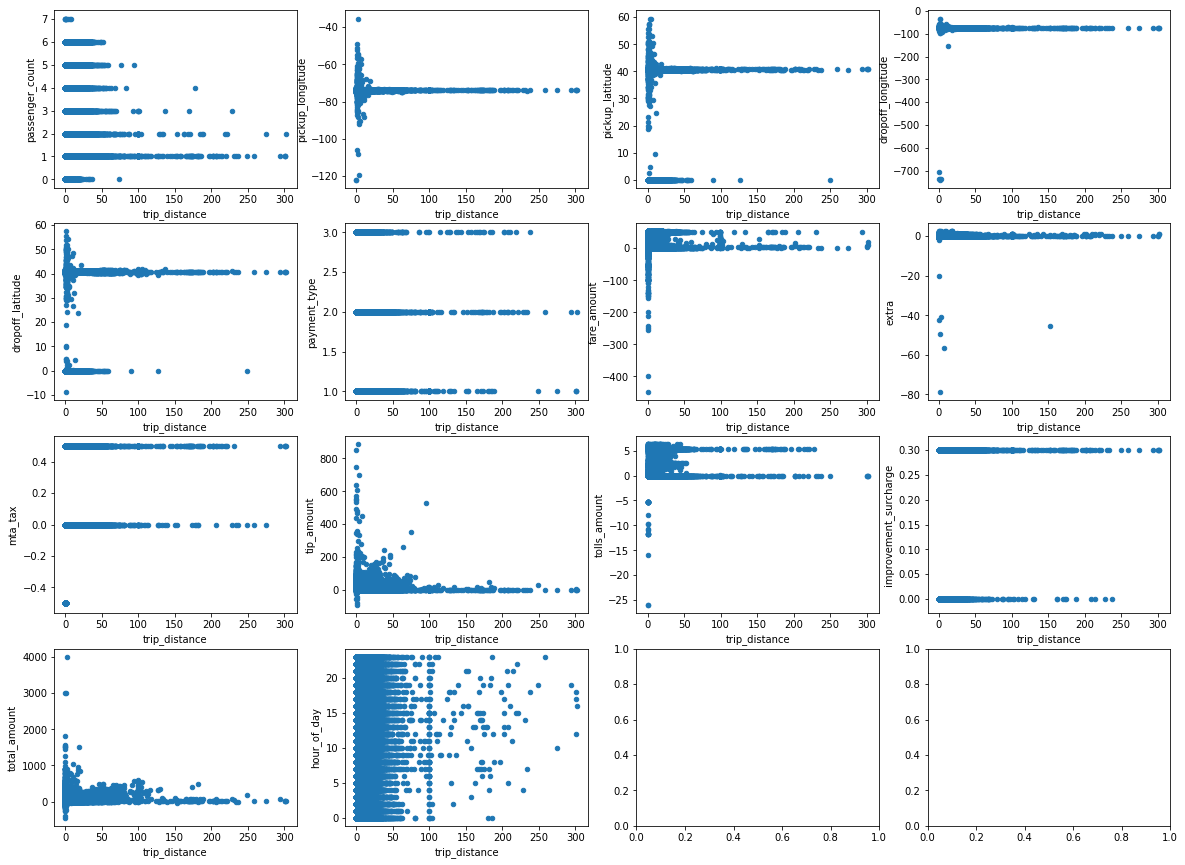

In [12]:
draw_list = [
    'passenger_count',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'payment_type',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'hour_of_day'
]
fig, axes = plt.subplots(nrows=len(draw_list)//4+1, ncols=4, figsize=(20, 15))
outlier_removed_df = df[ df.trip_distance < 400. ]
for index, colume_name in enumerate(draw_list):
    outlier_removed_df[ df[colume_name] < df[colume_name].mean() + 4.*df[colume_name].std()].plot.scatter( x='trip_distance', y=colume_name, ax=axes[index//4, index%4])

## 單次乘客數量與乘坐距離的關係
### 將 trip_distance 以 10 為間距做 bining，並將各個間距中的 **乘客平均數** 及 **乘客數標準差** 畫出如下圖：

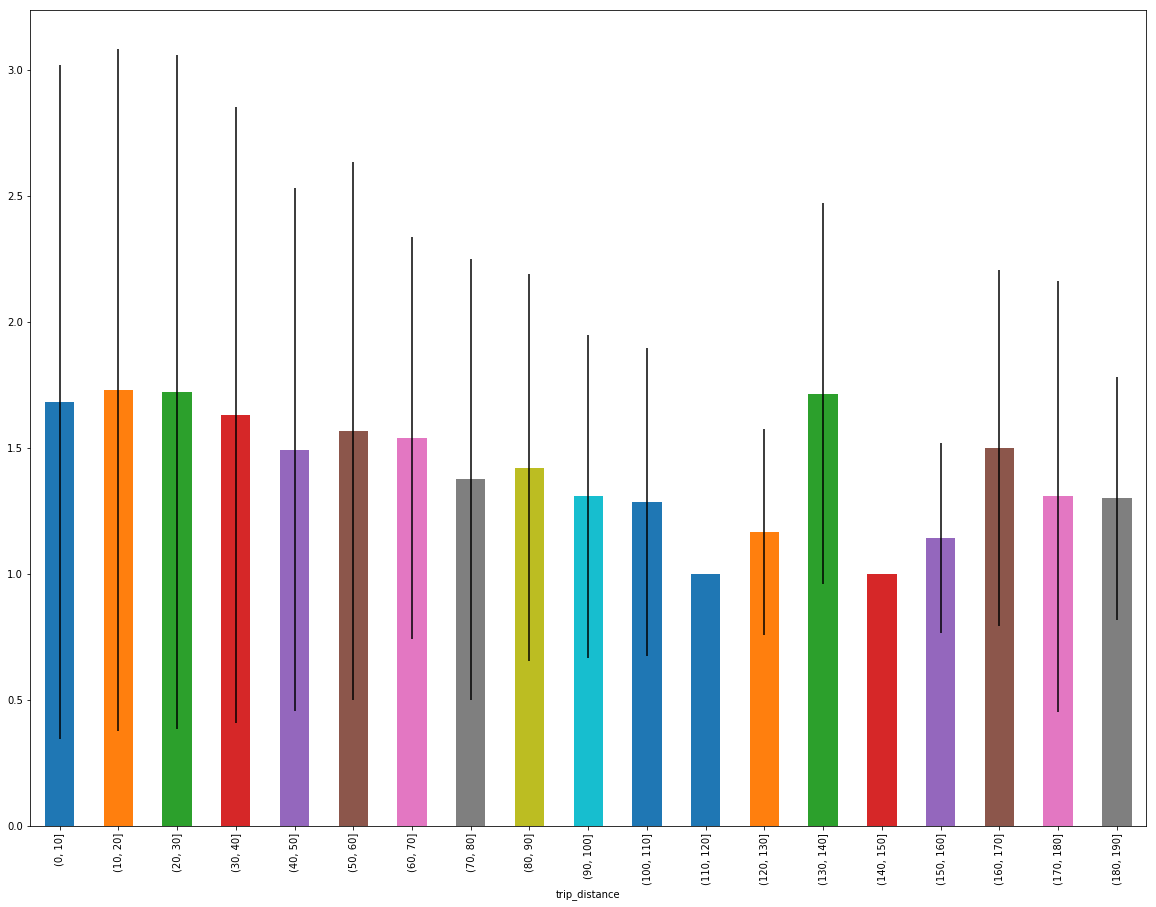

In [29]:
tmp_df = df[df.passenger_count > 0]
grouped_by_trip_distance_df = tmp_df.groupby(pd.cut(tmp_df['trip_distance'], np.arange(0, 200, 10)))

gbtd_passenger_count = grouped_by_trip_distance_df.passenger_count
gbtd_passenger_count.mean().plot.bar(figsize=(20, 15), yerr=gbtd_passenger_count.std())

* 可以看出雖然並不明顯，但是 **較遠的乘坐距離相對有較少的單次乘客數量**
* 而距離較短的乘坐距離標準差較大，可以看出 **距離較短的乘坐距離 有較多的 高單次乘客數量**

## 付費方式與乘坐距離的關係
#### 付費方式依照文件有以下幾種：
1. Credit card
2. Cash
3. No charge
4. Dispute
5. Unknown
6. Voided trip

#### 這處僅對信用卡及現金進行分析

In [72]:
grouped_by_trip_distance_df.payment_type.value_counts(normalize=True).to_csv('tmp.csv')
payment_counts = pd.read_csv('tmp.csv', names=['interval', 'payment_type', 'frequency'])
os.remove('tmp.csv')
payment_counts.head()

,interval,payment_type,frequency
0,"(0, 10]",1,6.171462e-01
1,"(0, 10]",2,3.798112e-01
2,"(0, 10]",3,2.280039e-03
3,"(0, 10]",4,7.623595e-04
4,"(0, 10]",5,1.656223e-07


#### 使用現金比例 對 乘坐距離（向右遞增）：

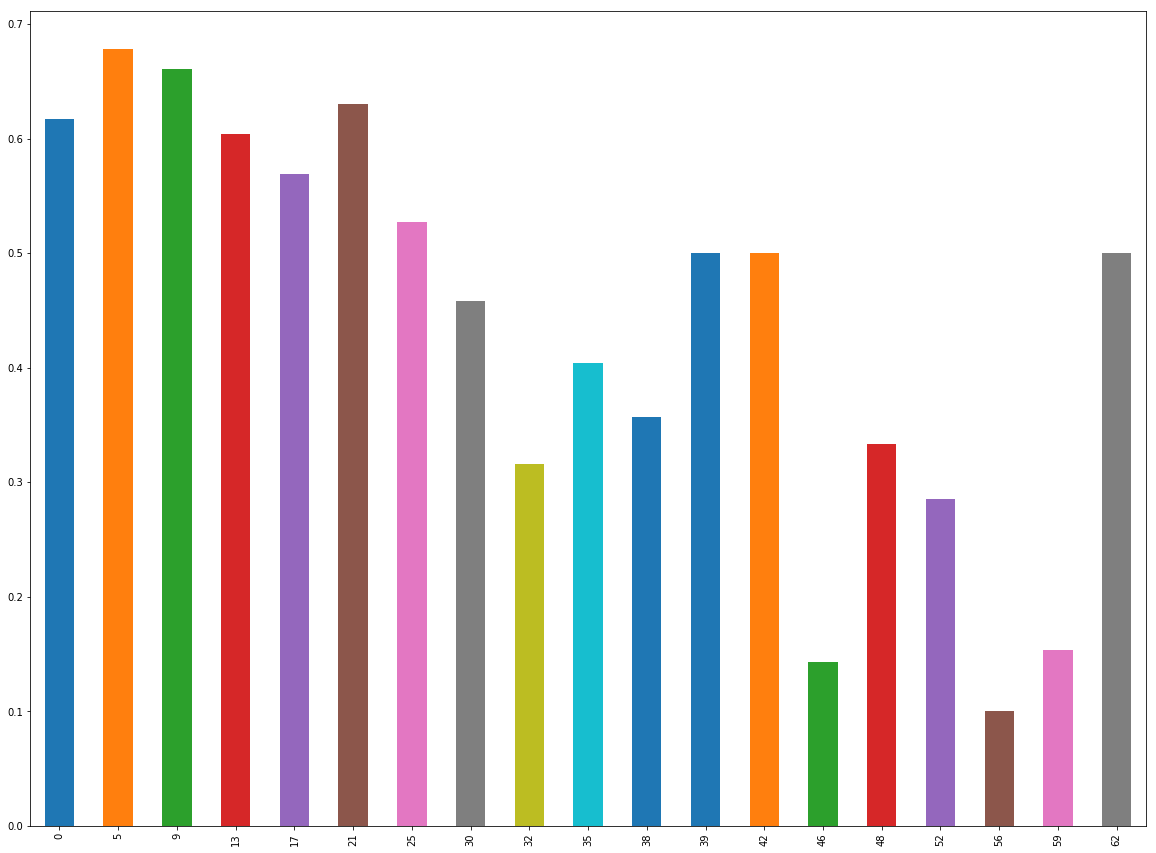

In [75]:
payment_counts[payment_counts.payment_type == 1].frequency.plot.bar(figsize=(20, 15))

* 可以發現 **隨著乘坐距離上升，付現的比例下降**
    * 此一發現也符合常理，過長的距離並不適合以現金支付